In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import random
import gc

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/slang-txt/Slang Text.csv
/kaggle/input/spam-emails/spam.csv


In [2]:
# Install libs we will use here
%pip install -q matplotlib scikit-learn contractions nltk spacy transformers torch sacremoses

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Download large spacy model
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Data

Dataset is taken from next kaggle dataset, [link](https://www.kaggle.com/datasets/abdallahwagih/spam-emails/data)

## Download dataset

In [4]:
# FYI: kaggle run
df = pd.read_csv('/kaggle/input/spam-emails/spam.csv')
fname_out = "/kaggle/working/spam_enriched.csv"

# # FYI: local run
#df = pd.read_csv(os.getcwd() + '/spam.csv')
#fname_out = os.getcwd() + '/spam_enriched.csv'

df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Simple EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
df["Category"].value_counts(normalize=True)

Category
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

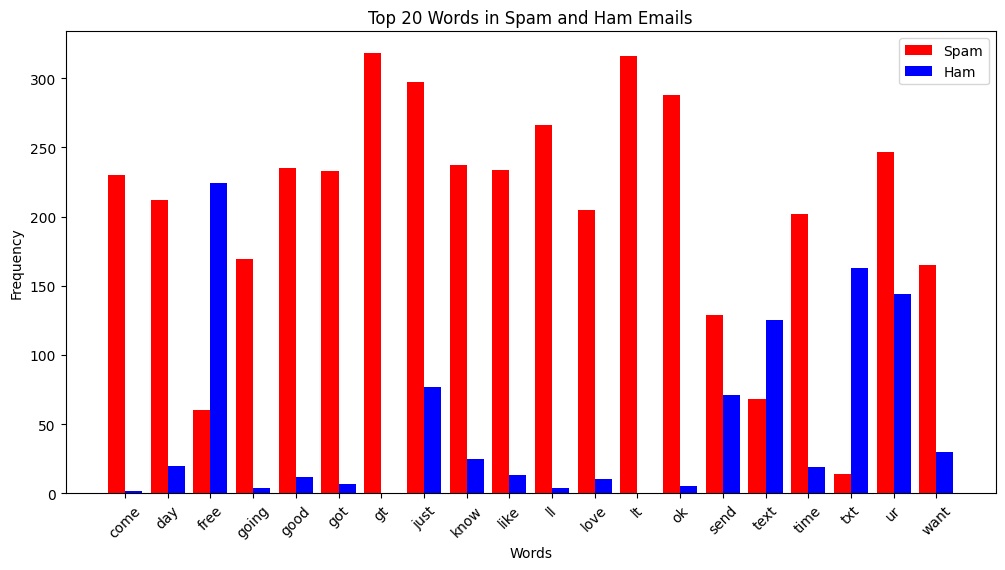

In [9]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=20, stop_words='english')
X_counts = vectorizer.fit_transform(df['Message'])

spam_df = df[df['Category'] == "ham"]
ham_df = df[df['Category'] == "spam"]

spam_counts = vectorizer.transform(spam_df['Message']).toarray().sum(axis=0)
ham_counts = vectorizer.transform(ham_df['Message']).toarray().sum(axis=0)

words = vectorizer.get_feature_names_out()
x = np.arange(len(words))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, spam_counts, width=0.4, label='Spam', color='red')
plt.bar(x + 0.2, ham_counts, width=0.4, label='Ham', color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Spam and Ham Emails')
plt.xticks(ticks=x, labels=words, rotation=45)
plt.legend()
plt.show()

Some summary:
- data is highly imbalanced: 86.6% not spam and 13.4% spam

# Data augmentation

Check and use main data augmenation in NLP:
1. Expanding Contractions;
2. Sentence Shuffling;
3. Dialects or Slangs;
4. Noise Injection:
    - Synonym Replacement;
    - Random Insertion; 
    - Random Deletion; 
    - Random Swap; 
5. Paraphrasing - model: `facebook/bart-large-cnn`;
6. Back Translation - model: `Helsinki-NLP/opus-mt-en-uk` and `Helsinki-NLP/opus-mt-uk-en`;
7. Text Generation using Language Models - model `GPT2`;

FYI: with `textaugment` lib it is possible to apply most of the techniques presented in this notebook easily. But to understand better what it does let's reveal how it works. 

In [10]:
# # TODO del this cell in the end
# df = pd.read_csv('/kaggle/working/spam_enriched.csv')
# df

## Expand Contraction

Expand Contraction in NLP data augmentation refers to the process of expanding contractions (e.g., "don't" becomes "do not") to their full form. This can be useful to normalize text, as expanded forms are sometimes easier for models to interpret. It can also provide variety in training data for models.

In [11]:
import contractions

def expand_contractions(text):
    # Expands contractions
    expanded_text = contractions.fix(text)
    
    return expanded_text

In [12]:
# Example text
text = "I can't believe it's already September. He doesn't like it."

print("Original Text:", text)
print("Expanded Text:", expand_contractions(text))

Original Text: I can't believe it's already September. He doesn't like it.
Expanded Text: I cannot believe it is already September. He does not like it.


In [13]:
# Proceed with email dataset
df["Message, expanded"] = list(map(expand_contractions, df["Message"]))
# Save the results
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 0.1s on hp laptop

## Sentence Shuffling

Sentence Shuffling involves shuffling the order of sentences within a text or paragraph. The goal is to provide the model with slightly different versions of the original text to improve its robustness. However, shuffling should be applied carefully to maintain the overall coherence of the text, especially for tasks like language modeling or text classification.

In [14]:
import spacy
import random

# Load the spaCy model for tokenization
nlp = spacy.load('en_core_web_lg')

def sentence_shuffling(text):
    # Tokenize the text into sentences using spaCy
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    
    # Shuffle the sentences
    random.shuffle(sentences)
    
    # Join the shuffled sentences back into a single text
    shuffled_text = ' '.join(sentences)
    
    return shuffled_text

In [15]:
# Example text
text = """I love natural language processing. It is a fascinating field. Techniques like data augmentation help improve model performance."""

print("Original Text:\n", text)
print("\nShuffled Text:\n", sentence_shuffling(text))

Original Text:
 I love natural language processing. It is a fascinating field. Techniques like data augmentation help improve model performance.

Shuffled Text:
 I love natural language processing. Techniques like data augmentation help improve model performance. It is a fascinating field.


In [16]:
# Proceed with email dataset
df["Message, sent_shuflling"] = list(map(sentence_shuffling, df["Message"]))
# Save the results
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 26.4s on hp laptop

## Dialects or Slangs

Using Different Dialects or Slang is a powerful NLP data augmentation technique where you alter the text by substituting formal or standard language with regional dialects, slang, or colloquialisms. This helps models become robust against linguistic variations that are common in real-world settings. It is particularly useful for chatbots, social media sentiment analysis, and any task where informal language is common.  

Challenges:
- Not all dialects or slang terms are easily replaceable, and some substitutions might alter the meaning of the sentence.
- You need a dictionary or set of rules for mapping standard language to slang or dialect variants.

In [17]:
# Download slang-txt dictionary
!kaggle datasets download -d swayamsinghal/slang-txt

Dataset URL: https://www.kaggle.com/datasets/swayamsinghal/slang-txt
License(s): CC-BY-SA-3.0
  0%|                                               | 0.00/2.46k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 2.46k/2.46k [00:00<00:00, 6.27MB/s]


In [18]:
# importing module
import csv

# For slangs: https://www.kaggle.com/datasets/swayamsinghal/slang-txt
#     csv file used Slang Text.csv
# for kaggle
filename = '/kaggle/input/slang-txt/Slang Text.csv'
# # for local development
# filename = os.getcwd() + '/Slang Text.csv'

slangs = {}
# opening the file using "with"
with open(filename,'r') as data:
   for line in csv.reader(data):
      slangs[line[0]] = line[1]

slangs

{'Abbreviation': 'Full Form',
 'abt': 'about',
 'abt2': 'about to',
 'acc': 'actually',
 'add': 'address',
 'afaik': 'as far as i know',
 'afk': 'away from keyboard',
 'aka': 'also known as',
 'asap': 'as soon as possible',
 'asf': 'as f***',
 'asl': 'age, sex, location',
 'atm': 'at the moment',
 'b': 'bisexual / babe',
 'b4': 'before',
 'based': 'used when agreeing with something; or recognising someone is being themselves',
 'bc': 'because',
 'bet': 'okay; affirming something',
 'bday': 'birthday',
 'blates': 'obviously',
 'bf': 'boyfriend/best friend',
 'bf4l or bffl': 'best friends for life',
 'bff': 'best friends forever',
 'boyf': 'boyfriend',
 'brb': 'be right back',
 'btw': 'by the way',
 'cap': 'lie',
 'cba': "can't be bothered",
 'cmb': 'call me back',
 'cmon': 'come on',
 'ctn': "can't talk now",
 'cu': 'see you',
 'cua': 'see you around',
 'cul': 'see you later',
 'cya': 'see ya',
 'da f/dafuq?': 'what the f***?',
 'diss': 'disrespect',
 'dkdc': "don't know, don't care",
 

In [19]:
import re

def replace_slang(text, slang_dict):
    # Create a regex pattern that matches slang terms from the dictionary
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b')
    
    # Replace slang terms with formal equivalents
    formal_text = pattern.sub(lambda x: slang_dict[x.group()], str.lower(text))
    
    return formal_text

In [20]:
# Example informal text with slang
informal_text = "I'm abt2 going cuz it's not too cold. Asap"

# Apply slang replacement using the slang dictionary
formal_text = replace_slang(informal_text, slangs)

print("Original Text:", informal_text)
print("After Slang Replacement:", formal_text)

Original Text: I'm abt2 going cuz it's not too cold. Asap
After Slang Replacement: i'male about to going cuz it's not too cold. as soon as possible


In [21]:
from itertools import repeat

# Proceed with email dataset
df["Message, slang_replacment"] = list(map(replace_slang, df["Message"], repeat(slangs)))
# Save the results
df.to_csv(fname_out, index=False)
# 0.6s on hp laptop

## Noise injection

Noise injection is a NLP data augmentation technique where noise is deliberately introduced into text data to improve model robustness. The idea is to simulate real-world imperfections or variations in text, such as typos, word swaps, or random deletions, allowing models to generalize better by training on slightly "noisy" data.

Common Types of Noise Injection:
- Character-level noise: This involves adding noise at the character level, such as swapping adjacent characters, adding random characters, or deleting characters.
- Word-level noise: In this approach, noise is introduced at the word level by randomly deleting, swapping, or replacing words in the sentence.
- Synonym replacement: Words are replaced with their synonyms to maintain meaning while changing the wording slightly.
- Random deletion: Randomly deleting words from a sentence.
- Word swapping: Two adjacent words in a sentence are swapped.

We will proceed with random deletion, insertion, and swaping, and synonym replacement. 

### Synonym Replacement with spacy


In [22]:
import spacy
import nltk
from nltk.corpus import wordnet as wn

# IDEA: instead of using nltk vocabls create one in spacy based on downloaded email dataset 
#    cons: augmentation (new samples) is limited by own dataset which is not good
# nltk.download('punkt')
nltk.download('wordnet')

# unzip to use in kaggle
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
#!unzip /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [23]:
# Load spaCy model
nlp = spacy.load('en_core_web_lg')

def get_synonyms(word):
    """Get synonyms of a word using WordNet."""
    #print(f'get_synonyms: word: {word}')
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)  # Remove the original word from the list of synonyms
    #print(f'get_synonyms: list of synonyms: {list(synonyms)}')
    return list(synonyms)

def replace_synonyms(text):
    """Replace words in the text with their synonyms."""
    #print(f'replace_synonyms: input text: {text}')
    doc = nlp(text)
    new_text = []
    for token in doc:
        synonyms = get_synonyms(token.text)
        # TODO use re.repl to find and replace word with rand synonym
        if synonyms:
            # Replace with a random synonym 
            new_word = synonyms[np.random.randint(0, len(synonyms))]
            #print(f'replace_synonyms: token: choosen synonym/word: {new_word}')
            new_text.append(new_word)
            #print(f'replace_synonyms: token: new_text: {new_text}')
        else:
            new_text.append(token.text)
    return ' '.join(new_text)

def process_samples(samples):
    """Process a list of text samples to replace synonyms."""
    return [replace_synonyms(sample) for sample in samples]

# Example usage:
samples = [
    "I love programming in Python.",
    "Natural language processing is fascinating.",
]

# Process the list of samples
new_samples = process_samples(samples)

# Print results
for original, new in zip(samples, new_samples):
    print(f"Original: {original}")
    print(f"Modified: {new}")
    print()

Original: I love programming in Python.
Modified: 1 sleep_with programing atomic_number_49 python .

Original: Natural language processing is fascinating.
Modified: lifelike lyric action be entrance .



It creates something ugly/ununderstandable, let's improve it by replacing only nouns, verbs, adjectives, and adverbs.  
And let's add spacy similarity to find the best similar synonym from the nltk wordnet corpus.

In [24]:
# Load spaCy model
nlp = spacy.load('en_core_web_lg')

def get_wordnet_pos(spacy_pos):
    """Convert spaCy POS tags to WordNet POS tags."""
    if spacy_pos == 'NOUN':
        return wn.NOUN
    elif spacy_pos == 'VERB':
        return wn.VERB
    elif spacy_pos == 'ADJ':
        return wn.ADJ
    elif spacy_pos == 'ADV':
        return wn.ADV
    else:
        return None

def get_synonyms_nltk(word):
    """Get synonyms of a word using WordNet, filtered by POS (nouns and verbs only)."""
    #print(f'get_synonyms: input word: {word.text}; {word.pos_}')
    synonyms = set()
    wn_pos = get_wordnet_pos(word.pos_)
    #print(f'nltk synonym: {wn.synsets(word.text, pos=wn_pos)}')
    if wn_pos:
        for syn in wn.synsets(word.text, pos=wn_pos):
            #print('syn:', syn)
            #print('syn.lemmas:', syn.lemmas())
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
    # Remove the original word from the set of synonyms
    synonyms.discard(word.text)
    #print(f'get_synonyms: synonyms: {synonyms}')
    
    return list(synonyms)

def get_best_synonym(token):
    """Replace a token with the most similar synonym."""
    synonyms = get_synonyms_nltk(token)
    
    # Return original world if there no synonyms 
    if not synonyms:
        return token.text
    
    # Create a spaCy Doc for each synonym (and tokenize it)
    synonym_docs = [nlp(syn) for syn in synonyms]

    #print(f'word: {token}')
    #print(f'synonyms: {synonyms}')
    #print(f'synonym_docs: {synonym_docs}')
    
    # Compute similarity scores
    similarity_scores = [token.similarity(syn_doc) for syn_doc in synonym_docs]
    #print(f'replace_with_best_synonym: similarity scores: {similarity_scores} \n')
     
    # Find the synonym with the highest similarity score
    best_synonym = synonyms[similarity_scores.index(max(similarity_scores))]
    #print(f'replace_with_best_synonym: best synonym: {best_synonym}')

    return best_synonym

def replace_synonyms_in_sentence(text):
    """Replace nouns and verbs in the text with their most similar synonyms."""
    #print(f'replace_synonyms: raw text: {text}')
    doc = nlp(text)
    new_text = text
    
    for token in doc:
        #print(f'token: {token}')
        if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV'):
            new_word = get_best_synonym(token)
            #print(f'new_word: {new_word}')
            new_text = new_text.replace(token.text, new_word)
        else:
            pass
    
    return new_text

In [25]:
# Example usage:
def debug_replace_synonyms_in_sentence(samples):
    """Process a list of text samples to replace synonyms."""
    
    new_samples = []

    for sample in samples:
        print(f"sample: {sample}")
        new_sample = replace_synonyms_in_sentence(sample)
        print(f"new_sample: {new_sample} \n")
        new_samples += [new_sample]
    
    return new_samples

samples = [
    "I love programming in Python.",
    "Natural language processing is fascinating.",
]

# Process the list of samples
new_samples = debug_replace_synonyms_in_sentence(samples)

sample: I love programming in Python.
new_sample: I enjoy program in Python. 

sample: Natural language processing is fascinating.
new_sample: natural terminology processing is captivating. 



/tmp/ipykernel_23/2163421125.py:51: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_scores = [token.similarity(syn_doc) for syn_doc in synonym_docs]


Not perfect. But much much better! Let's use it to create additional samples in our original dataset.

Next cell takes time (~1 hour on standard kaggle 3GiB RAM CPU) since we have more than 5500 samples and many many words inside.

In [26]:
# takes ~45 minutes on standard kaggle CPU with 5GiB RAM
df["Message, synonymized"] = list(map(replace_synonyms_in_sentence, df["Message"]))
# Save the results in the file to be able to commit this cell in the future
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 20m38s on hp laptop

/tmp/ipykernel_23/2163421125.py:51: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_scores = [token.similarity(syn_doc) for syn_doc in synonym_docs]


### Random Insertion

Random words from a sentence are selected (stop words are not considered), and synonyms of these words are inserted back into the sentence at random positions. 

In [27]:
import random

# Function to get synonyms (simple version, can be replaced with WordNet or a synonym library)
def get_synonyms_spacy(word):
    synonyms = []
    for syn in word.vocab.vectors.most_similar(word.vector.reshape(1, word.vector.shape[0]), n=10)[0][0]:
        synonym = nlp.vocab[syn].text
        if synonym != word.text:  # Avoid the original word
            synonyms.append(synonym)
    return synonyms

# Random Insertion technique (excluding stop words and punctuations)
def random_insertion(text, n=1):
    #print(f'input text: {text}')
    doc = nlp(text)
    
    # List of non-stop words and non-punctuation
    non_stop_words = [token.text for token in doc if not token.is_stop and token.pos_ not in ['PUNCT', 'SPACE']]
    #print(f'list of eligible words for synonym creation: {non_stop_words}')
    
    if len(non_stop_words) == 0:  # If no valid words to insert
        return text
    
    new_sentence = text.split()
    #print(f'splitted sentence: {new_sentence}')
    
    for _ in range(n):
        # Randomly choose a non-stop word to augment
        random_word = random.choice(non_stop_words)
        #print(f'chosen word for synonym creation: {random_word}')
        
        # Get synonyms
        token = nlp(random_word)[0]
        synonyms = get_synonyms_spacy(token)
        #print(f'synonyms to the above word: {synonyms}')
        
        if synonyms:
            synonym = random.choice(synonyms)
            #print(f'randomly picked synonym: {synonym}')
            insert_position = random.randint(0, len(new_sentence))
            #print(f'randomly picked insert position: {insert_position}')
            new_sentence.insert(insert_position, synonym)
            #print(f'new sentence with inserted synonym: {new_sentence}')
    
    return ' '.join(new_sentence)

In [28]:
# Example usage
text = "The quick brown fox jumps over the lazy dog."
augmented_text = random_insertion(text, n=2)
print("Original:", text)
print("Augmented:", augmented_text)

Original: The quick brown fox jumps over the lazy dog.
Augmented: The quick brown fox jumps over the quicks lazy pup dog.


In [29]:
# takes an ~2h on standard kaggle CPU with 3GiB RAM
df["Message, rand_inserted"] = list(map(random_insertion, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 81m37s on hp laptop

### Random deletion

Randomly delete some words within sentences.

In [30]:
import random

# Function to randomly delete a word
def delete_random_word(raw_text, prob=0.2):
    # Split input text by space
    words = raw_text.split()
    # Calculate number of words to delete from text
    n_words_to_delete = int(len(words) * prob)

    # Proceed with deletation
    for i in range(n_words_to_delete):
        word_ind_to_del = random.randint(0, len(words)-1)
        del words[word_ind_to_del]
    
    return " ".join(words)

In [31]:
# Example usage
text = "The quick brown fox jumps over the lazy dog."
text_updated = delete_random_word(text, prob=0.3)
print("Original:", text)
print("Noisy:", text_updated)

Original: The quick brown fox jumps over the lazy dog.
Noisy: The quick jumps over the lazy dog.


In [32]:
df["Message, rand_deleted"] = list(map(delete_random_word, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 0.1s on hp laptop

### Random Swap

Two words from a sentence are randomly selected and their positions are swapped

In [33]:
def random_swap(text, n=1):
    """Split the sentence into words (punctuation marks here belong 
        to words, if you want to treat them separately it is possible
        by using regular expression or nltk/spacy/etc lib solution)
    """
    words = text.split()
    
    # Perform n swaps
    for _ in range(n):
        # Ensure there are at least two words to swap
        if len(words) < 2:
            return text
        
        # Randomly select two different indices to swap
        idx1, idx2 = random.sample(range(len(words)), 2)
        
        # Swap the words at the selected indices
        words[idx1], words[idx2] = words[idx2], words[idx1]
    
    # Join the words back into a sentence
    return ' '.join(words)

In [34]:
# Example usage
text = "The quick brown fox jumps over the lazy dog."
augmented_text = random_swap(text, n=2)
print("Original:", text)
print("Augmented:", augmented_text)

Original: The quick brown fox jumps over the lazy dog.
Augmented: The lazy brown dog. jumps over the quick fox


In [35]:
# Run on email dataset
df["Message, rand_swap"] = list(map(random_swap, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 0.1s on hp laptop

## Paraphrasing BART

Sentence rephrasing using BART model from HuggingFace.

In [36]:
from transformers import pipeline
import torch

# Choose the model from HyggingFace
model = "facebook/bart-large-cnn"

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the paraphrase model (BART or T5 are popular for paraphrasing)
paraphrase_pipeline = pipeline("text2text-generation", 
                               model=model, 
                               device=device,
                               clean_up_tokenization_spaces = True)

def paraphrase_text(doc):
    """
    Paraphrase the given text and return multiple variations.
    
    Args:
        doc (str): Input text to paraphrase.
    
    Returns:
        list: A list of paraphrased docs.
    """
    # Generate paraphrased versions
    paraphrased = paraphrase_pipeline(doc, do_sample=True)
    #print(f'pipeline output: {paraphrased[0]["generated_text"]}')
   
    return paraphrased[0]["generated_text"]


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:
# Example sentence
sentence = "Data augmentation helps in improving the performance of machine learning models. \
For more information check HuggingFace."

# Get paraphrased sentences
paraphrased_sentences = paraphrase_text(sentence)
print(f"Paraphrased: {paraphrased_sentences}")

Paraphrased: Data augmentation helps in improving the performance of machine learning models. For more information check HuggingFace.com and follow them on Twitter @HuggingFace and @huggingface on Facebook. The blog is also available on Google Play and is available on Amazon.com.


In [38]:
# Process email dataset in batches 

# Batch size
batch_size = 500
# Initiate empty paraphrased message
df["Message, paraphrased"] = ''

# Loop through the list in batches
for i in range(0, len(df), batch_size):
    paraphrased = paraphrase_pipeline(list(df.loc[i:i+batch_size-1, "Message"]), do_sample=True)
    df.loc[i:i+batch_size-1, "Message, paraphrased"] = list([d["generated_text"] for d in paraphrased])

# Save batch results
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [39]:
import gc

# Remove pipeline and free CPU/GPU memory
del paraphrase_pipeline
gc.collect()
if device == 'cuda': torch.cuda.empty_cache() 


## Back Translation

models: `Helsinki-NLP/opus-mt-en-uk` and `Helsinki-NLP/opus-mt-uk-en`

In [40]:
from transformers import pipeline
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define pipelines out of the method so in case it will be used in the look it will not load every time
translator_en_uk = pipeline("translation_en_to_uk", 
                            model="Helsinki-NLP/opus-mt-en-uk", 
                            clean_up_tokenization_spaces=True,
                            device=device)
translator_uk_en = pipeline("translation_uk_to_en",
                            model="Helsinki-NLP/opus-mt-uk-en",
                            clean_up_tokenization_spaces=True,
                            device=device)

def generate_back_translations(texts):
    """
    Tranlate English text into Ukrainian and then back into English.
    
    Args:
        doc (str): Input text for back translation.
    
    Returns:
        uk_transl, en_transl (tuple): A tuple with Ukrainian and back translated English text.
    """
    # Tranlate English text into Ukrainian
    uk_translations = translator_en_uk(texts)
    uk_translations_list = [d['translation_text'] for d in uk_translations]
    # Translate Ukrainian text back into English
    en_back_transl = translator_uk_en(uk_translations_list)
    en_back_transl_list = [d['translation_text'] for d in en_back_transl]

    return uk_translations_list, en_back_transl_list


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

In [41]:
# Example sentence
text = "The quick brown fox jumps over the lazy dog."
uk_translation, back_translated = generate_back_translations(text)

print(f"Original text in English: {text}")
print(f"Ukrainian translation: {uk_translation[0]}")
print(f"Back translated text in English: {back_translated[0]}")

Original text in English: The quick brown fox jumps over the lazy dog.
Ukrainian translation: Швидка коричнева лисиця стрибає через лінивого собаку.
Back translated text in English: A fast brown fox leaps over a lazy dog.


In [42]:
# Run on email dataset
uk_translations, df["Message, back_translated"] = generate_back_translations(list(df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

# Remove pipeline and free CPU/GPU memory
del translator_en_uk, translator_uk_en
gc.collect()
if device == 'cuda': torch.cuda.empty_cache() 

## Text Generation using Language Models

Text generation in the context of Natural Language Processing (NLP) data augmentation involves creating new text samples based on existing data. It is particularly useful when there is a limited amount of labeled data available for training machine learning models. By generating synthetic data, models can be trained on a more diverse set of inputs, which can improve their generalization ability.

In [43]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2-large'  # You can use 'gpt2-medium', 'gpt2-large', etc.
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, device=device, clean_up_tokenization_spaces=True)

# Set the model in evaluation mode (for inference)
model.eval()

def generate_text_using_llm(start_text, max_new_tokens):

    # Tokenize the input text and create attention mask
    input_ids = tokenizer.encode(start_text, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    # Generate text (specify the maximum length for the generated text)
    output = model.generate(
        input_ids, 
        attention_mask=attention_mask,  # Pass attention mask explicitly to avoid warning
        max_new_tokens=max_new_tokens, 
        no_repeat_ngram_size=2,
        pad_token_id=tokenizer.eos_token_id,  # Ensure padding is handled correctly
    )
    
    # Decode and return generated text
    for i, generated_sequence in enumerate(output):
        generated_text = tokenizer.decode(generated_sequence, skip_special_tokens=True)
 
    return generated_text

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [44]:
# Text prompt (the input for the model)
input_text = "The future of AI is"
max_new_tokens = 50

# Decode and print the generated text
generated_text = generate_text_using_llm(input_text, max_new_tokens)
print(f"Generated Text: {generated_text}\n")

Generated Text: The future of AI is in the hands of the people who build it.

The AI industry is a $1.5 trillion industry, and it's growing at a rate of about 10% per year. The industry has been growing for the last decade, but it



In [45]:
# Proceed with email dataset
number_of_input_words = 7
df["Message, generated"] = ""

# Loop to generate text by text
for ind, email in enumerate(df['Message']):
    
    # split email by words by space character
    words = email.split() 
    
    # define first words 
    input_text = " ".join(words[:number_of_input_words]) 
    
    # define max number of tokens to generate
    max_new_tokens = random.randint(len(words),len(words)+10) 

    # Generate text 
    df.loc[ind, "Message, generated"] = generate_text_using_llm(input_text, max_new_tokens)
    #print(f"{max_new_tokens}: {input_text}")
    #print(f"Generated: {df.loc[ind, "Message, generated"]}")

# Save the results
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

In [46]:
# Remove pipeline and free CPU/GPU memory
del model, tokenizer
gc.collect()
if device == 'cuda': torch.cuda.empty_cache() 

# Classifiers

Now, let's create two ML models that will learn and be able to predict whether the message is spam or ham.

Let's start with the origin dataset without additional augmented data.

## Naive Bayes classifier

I choose MultinomialNB instead of ComplementNB here since it shows better results. Try it yourself, just comment on one model and uncomment another within Step 5 in the cell below.

Multinomial Naive Bayes (MultinomialNB)  
It implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

Complement Naive Bayes (ComplementNB)  
**Designed for imbalanced data:** ComplementNB was specifically created to address some of the weaknesses of MultinomialNB when dealing with imbalanced data. It focuses on the complement of each class, helping it perform better on minority classes.  
**How it works:** Unlike MultinomialNB, which estimates the likelihood of each class, ComplementNB estimates the likelihood of not being in the class, which helps mitigate the dominance of the majority class.

More info at scikit-learn doc [link](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.97      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



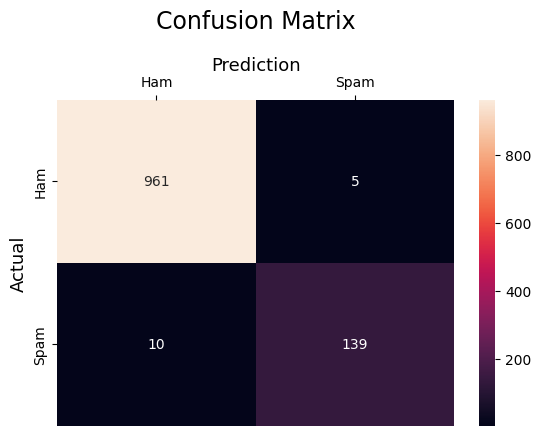

In [47]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split dataset into features (X) and labels (y)
X = df['Message'].values     # This is the text of the emails
y = df['Category']    # This is the spam/ham label (e.g., 'spam' or 'ham')

# # Encode labels
# y_encoded = LabelEncoder().fit_transform(y)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(f'lenght of X_train: {len(X_train)};\nlenght of X_test: {len(X_test)};')

# Step 3: Create the CountVectorizer and fit it on the training data only
# Transform the training text data into numeric feature vectors removing stop_words before
vectorizer = CountVectorizer(stop_words='english')
X_train_transformed = vectorizer.fit_transform(X_train)

# Step 4: Transform the test data using the same vectorizer (without fitting again)
# This ensures that only the words learned from the training set are used in the test set
X_test_transformed = vectorizer.transform(X_test)

# Step 5: Train the Naive Bayes model
model = MultinomialNB(fit_prior=True) # fit_prior to handle imbalance
# model = ComplementNB()
model.fit(X_train_transformed, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_transformed)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 8: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Ham','Spam'],
            yticklabels=['Ham','Spam'])
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Support Vector Machine (SVM) classifier

We use the class_weight='balanced' since our dataset is imbalanced.  
We use a linear kernel for text classification, reasons:
- In text classification, the data often lies in high-dimensional sparse spaces (many features but most of them are zeros, e.g., from TF-IDF or CountVectorizer representations). A linear kernel can effectively separate classes in this space.
- The linear kernel is computationally much faster than non-linear kernels, especially when working with high-dimensional text data.
- In text classification problems like spam detection, the relationship between features (words) and the target (spam/ham) is often linear, which is why a linear kernel performs well.

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



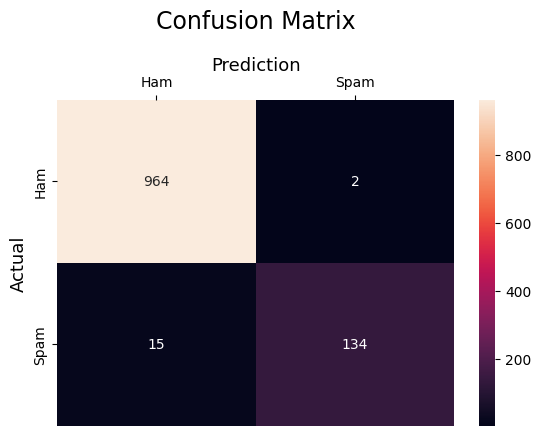

In [48]:
# Import necessary libraries
from sklearn.svm import SVC

# Step 1: Split dataset into features (X) and labels (y)
X = df['Message']     # This is the text of the emails
y = df['Category']    # This is the spam/ham label (e.g., 'spam' or 'ham')

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the CountVectorizer and fit it on the training data only
# Transform the training text data into numeric feature vectors removing stop_words before
vectorizer = CountVectorizer(stop_words='english')
X_train_transformed = vectorizer.fit_transform(X_train)

# Step 4: Transform the test data using the same vectorizer (without fitting again)
X_test_transformed = vectorizer.transform(X_test)

# Step 5: Train the Support Vector Machine (SVM) model
model = SVC(kernel='linear', class_weight='balanced')  
model.fit(X_train_transformed, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_transformed)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 8: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Ham','Spam'],
            yticklabels=['Ham','Spam'])
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()